In [1]:
import tqdm
import copy
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 10})
import torch
torch.manual_seed(42)

In [2]:
import sys
sys.path.append("../src/")

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import updates
import utils

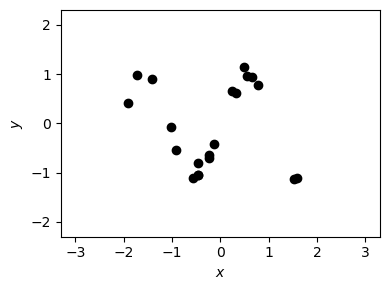

In [3]:
N = 20
random_state = np.random.RandomState(42)
X_numpy = random_state.randn(N)
y_numpy = np.sin(3 * X_numpy) + 0.1 * random_state.randn(N)

X = torch.tensor(X_numpy.reshape(-1, 1), dtype=torch.float32)
y = torch.tensor(y_numpy.reshape(-1, 1), dtype=torch.float32)

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

ax.scatter(X_numpy, y_numpy, color="#000000")
ax.set_xlim([-3.3, 3.3])
ax.set_ylim([-2.3, 2.3])
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

fig.tight_layout()
plt.show()

In [4]:
phi = layers.RandomFourierFeatures(in_features=1, learnable_lengthscale=True, learnable_outputscale=True, lengthscale=1.0, outputscale=1.0, rank=1_024)
init_state_dict = copy.deepcopy(phi.state_dict())
phi.load_state_dict(init_state_dict)

optimizer = torch.optim.Adam(phi.parameters(), lr=0.1)

sigma_y2_star = torch.tensor(1.0)
tau = torch.tensor(1.0)
temp = torch.tensor(1.0)

losses = []

for _ in tqdm.tqdm(range(1_000)):
    
    with torch.no_grad():
        Phi = phi(X)
        mu_q_star = updates.diag_mu_q_update(Phi, sigma_y2_star, y, tau=tau, temp=temp)
        sigma_q2_star = updates.diag_sigma_q2_update(Phi, sigma_y2_star, tau=tau, temp=temp)
        sigma_y2_star = updates.diag_sigma_y2_update(mu_q_star, Phi, sigma_q2_star, y)

    optimizer.zero_grad()
    elbo = utils.diag_elbo(mu_q_star, phi(X), sigma_q2_star, sigma_y2_star, y, tau=tau, temp=temp)
    (-elbo).backward()
    optimizer.step()
    
    losses.append(-elbo.item())
    

100%|██████████| 1000/1000 [00:20<00:00, 49.04it/s]


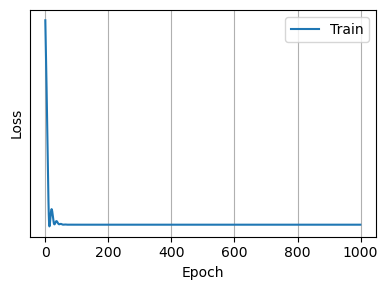

In [5]:
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

ax.plot(range(len(losses)), losses, label="Train")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_yscale("symlog")
ax.legend()
ax.grid()

fig.tight_layout()

plt.show()


In [6]:
diag_noise = sigma_y2_star.item()
diag_lengthscale = phi.lengthscale.item()
diag_outputscale = phi.outputscale.item()
diag_elbo = -losses[-1]
diag_lml = utils.lml(phi(X), sigma_y2_star, y, tau=tau).item()

In [7]:
X_star = torch.linspace(start=-3.3, end=3.3, steps=1_000).view(-1, 1)
Phi_star = phi(X_star)

with torch.no_grad():
    
    Sigma_q_star = sigma_q2_star.diag()
    L_q_star = torch.linalg.cholesky(Sigma_q_star)
    posterior = torch.distributions.multivariate_normal.MultivariateNormal(mu_q_star.view(-1), scale_tril=L_q_star)
    
    diag_mean = Phi_star @ mu_q_star
    
    diag_samples = []
    for _ in tqdm.tqdm(range(10_000)):
        diag_samples.append(Phi_star @ posterior.sample() + torch.sqrt(sigma_y2_star).item() * torch.randn(size=(1_000,)))
    diag_samples = torch.stack(diag_samples)
    

100%|██████████| 10000/10000 [00:03<00:00, 3132.16it/s]


In [8]:
phi = layers.RandomFourierFeatures(in_features=1, learnable_lengthscale=True, learnable_outputscale=True, lengthscale=1.0, outputscale=1.0, rank=1_024)
phi.load_state_dict(init_state_dict)

optimizer = torch.optim.Adam(phi.parameters(), lr=0.1)

eps = torch.tensor(1e-6)
sigma_y2_star = torch.tensor(1.0)
tau = torch.tensor(1.0)
temp = torch.tensor(1.0)

losses = []

for _ in tqdm.tqdm(range(1_000)):
    
    with torch.no_grad():
        
        Phi = phi(X)
        v_q_star = updates.rank1_v_q_update(eps, Phi, tau=tau, temp=temp)
        mu_q_star = updates.rank1_mu_q_update(Phi, sigma_y2_star, y, tau=tau, temp=temp)
        sigma_y2_star = updates.rank1_sigma_y2_update(eps, mu_q_star, Phi, v_q_star, y)

    optimizer.zero_grad()
    elbo = utils.rank1_elbo(eps, mu_q_star, phi(X), sigma_y2_star, v_q_star, y, tau=tau, temp=temp)
    (-elbo).backward()
    optimizer.step()
    
    losses.append(-elbo.item())
    

100%|██████████| 1000/1000 [01:24<00:00, 11.78it/s]


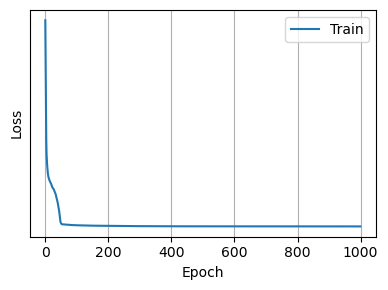

In [9]:
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

ax.plot(range(len(losses)), losses, label="Train")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_yscale("symlog")
ax.legend()
ax.grid()

fig.tight_layout()

plt.show()


In [10]:
rank1_noise = sigma_y2_star.item()
rank1_lengthscale = phi.lengthscale.item()
rank1_outputscale = phi.outputscale.item()
rank1_elbo = -losses[-1]
rank1_lml = utils.lml(phi(X), sigma_y2_star, y, tau=tau).item()

In [11]:
X_star = torch.linspace(start=-3.3, end=3.3, steps=1_000).view(-1, 1)
Phi_star = phi(X_star)

with torch.no_grad():
    
    Sigma_q_star = v_q_star @ v_q_star.T + eps * torch.eye(n=phi.rank)
    L_q_star = torch.linalg.cholesky(Sigma_q_star)
    posterior = torch.distributions.multivariate_normal.MultivariateNormal(mu_q_star.view(-1), scale_tril=L_q_star)
    
    rank1_mean = Phi_star @ mu_q_star
    
    rank1_samples = []
    for _ in tqdm.tqdm(range(10_000)):
        rank1_samples.append(Phi_star @ posterior.sample() + torch.sqrt(sigma_y2_star).item() * torch.randn(size=(1_000,)))
    rank1_samples = torch.stack(rank1_samples)
    
    rank1_posterior_samples = []
    for _ in tqdm.tqdm(range(3)):
        rank1_posterior_samples.append(Phi_star @ posterior.sample())
    rank1_posterior_samples = torch.stack(rank1_posterior_samples)
    

100%|██████████| 3/3 [00:00<00:00, 670.80it/s]


In [12]:
phi = layers.RandomFourierFeatures(in_features=1, learnable_lengthscale=True, learnable_outputscale=True, lengthscale=1.0, outputscale=1.0, rank=1_024)
phi.load_state_dict(init_state_dict)

optimizer = torch.optim.Adam(phi.parameters(), lr=0.1)

sigma_y2_star = torch.tensor(1.0)
tau = torch.tensor(1.0)
temp = torch.tensor(1.0)

losses = []

for _ in tqdm.tqdm(range(1_000)):
    
    with torch.no_grad():
        Phi = phi(X)
        mu_q_star = updates.fullrank_mu_q_update(Phi, sigma_y2_star, y, tau=tau, temp=temp)
        Sigma_q_star = updates.fullrank_Sigma_q_update(Phi, sigma_y2_star, tau=tau, temp=temp)
        sigma_y2_star = updates.fullrank_sigma_y2_update(mu_q_star, Phi, Sigma_q_star, y)

    optimizer.zero_grad()
    elbo = utils.fullrank_elbo(mu_q_star, phi(X), Sigma_q_star, sigma_y2_star, y, tau=tau, temp=temp)
    (-elbo).backward()
    optimizer.step()
    
    losses.append(-elbo.item())
    

100%|██████████| 1000/1000 [02:29<00:00,  6.70it/s]


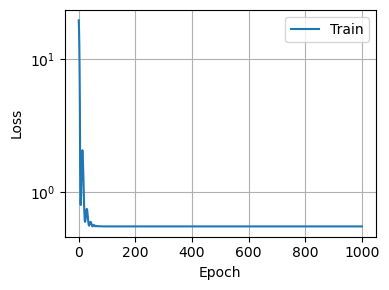

In [13]:
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

ax.plot(range(len(losses)), losses, label="Train")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_yscale("symlog")
ax.legend()
ax.grid()

fig.tight_layout()

plt.show()


In [14]:
fullrank_noise = sigma_y2_star.item()
fullrank_lengthscale = phi.lengthscale.item()
fullrank_outputscale = phi.outputscale.item()
fullrank_elbo = -losses[-1]
fullrank_lml = utils.lml(phi(X), sigma_y2_star, y, tau=tau).item()

In [15]:
X_star = torch.linspace(start=-3.3, end=3.3, steps=1_000).view(-1, 1)
Phi_star = phi(X_star)

with torch.no_grad():
    
    L_q_star = torch.linalg.cholesky(Sigma_q_star)
    posterior = torch.distributions.multivariate_normal.MultivariateNormal(mu_q_star.view(-1), scale_tril=L_q_star)
    
    fullrank_mean = Phi_star @ mu_q_star
    
    fullrank_samples = []
    for _ in tqdm.tqdm(range(10_000)):
        fullrank_samples.append(Phi_star @ posterior.sample() + torch.sqrt(sigma_y2_star).item() * torch.randn(size=(1_000,)))
    fullrank_samples = torch.stack(fullrank_samples)
    

100%|██████████| 10000/10000 [00:04<00:00, 2283.95it/s]


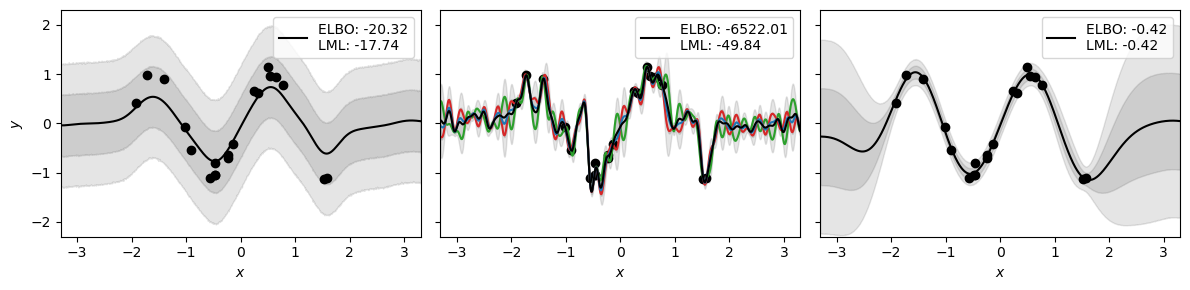

In [17]:
linspace = np.linspace(start=-3.3, stop=3.3, num=1000)

ncols, nrows = 3, 1
fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey="row")

axs[0].scatter(X_numpy, y_numpy, color="#000000")
axs[0].fill_between(linspace, diag_samples.mean(dim=0) + 2 * diag_samples.std(dim=0), diag_samples.mean(dim=0) - 2 * diag_samples.std(dim=0), alpha=0.1, color="#000000")
axs[0].fill_between(linspace, diag_samples.mean(dim=0) + 1 * diag_samples.std(dim=0), diag_samples.mean(dim=0) - 1 * diag_samples.std(dim=0), alpha=0.1, color="#000000")
axs[0].plot(linspace, diag_mean, color="#000000", label=f"ELBO: {diag_elbo:.2f}\nLML: {diag_lml:.2f}")
axs[0].set_xlim([-3.3, 3.3])
axs[0].set_ylim([-2.3, 2.3])
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$y$")
axs[0].legend(loc="upper right")

axs[1].scatter(X_numpy, y_numpy, color="#000000")
axs[1].fill_between(linspace, rank1_samples.mean(dim=0) + 2 * rank1_samples.std(dim=0), rank1_samples.mean(dim=0) - 2 * rank1_samples.std(dim=0), alpha=0.1, color="#000000")
axs[1].fill_between(linspace, rank1_samples.mean(dim=0) + 1 * rank1_samples.std(dim=0), rank1_samples.mean(dim=0) - 1 * rank1_samples.std(dim=0), alpha=0.1, color="#000000")
axs[1].plot(linspace, rank1_posterior_samples[0], color="#2CA02C")
axs[1].plot(linspace, rank1_posterior_samples[1], color="#D62728")
axs[1].plot(linspace, rank1_posterior_samples[2], color="#1F77B4")
axs[1].plot(linspace, rank1_mean, color="#000000", label=f"ELBO: {rank1_elbo:.2f}\nLML: {rank1_lml:.2f}")
axs[1].set_xlim([-3.3, 3.3])
axs[1].set_ylim([-2.3, 2.3])
axs[1].set_xlabel(r"$x$")
axs[1].legend(loc="upper right")

axs[2].scatter(X_numpy, y_numpy, color="#000000")
axs[2].fill_between(linspace, fullrank_samples.mean(dim=0) + 2 * fullrank_samples.std(dim=0), fullrank_samples.mean(dim=0) - 2 * fullrank_samples.std(dim=0), alpha=0.1, color="#000000")
axs[2].fill_between(linspace, fullrank_samples.mean(dim=0) + 1 * fullrank_samples.std(dim=0), fullrank_samples.mean(dim=0) - 1 * fullrank_samples.std(dim=0), alpha=0.1, color="#000000")
axs[2].plot(linspace, fullrank_mean, color="#000000", label=f"ELBO: {fullrank_elbo:.2f}\nLML: {fullrank_lml:.2f}")
axs[2].set_xlim([-3.3, 3.3])
axs[2].set_ylim([-2.3, 2.3])
axs[2].set_xlabel(r"$x$")
axs[2].legend(loc="upper right")

fig.tight_layout()
fig.savefig("under_overfitting.pdf", bbox_inches="tight")
plt.show()